### Import needed libraries
### Get the stock price history
### Display it in a plot

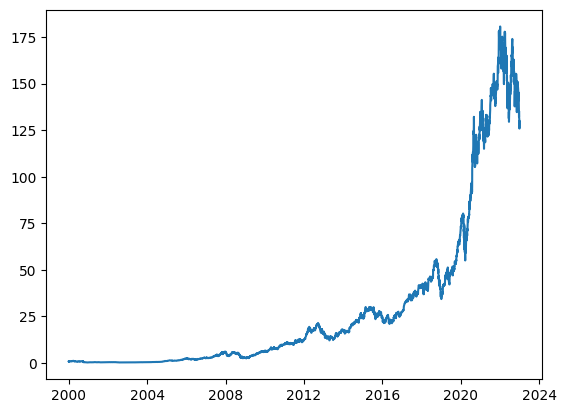

In [116]:
import yfinance
from matplotlib import pyplot as plt
import json
from datetime import *
import pandas as pd

stock_abbr = 'AAPL'
start, end = '1999-12-31', '2022-12-31'

stock_ticker = yfinance.Ticker(stock_abbr)
stock = stock_ticker.history(start=start, end=end)

plt.plot(stock['Close'])
plt.show()


### Add the low and high prices of the stock from the day before to each row
### Find in what days there was a gap and its type

In [117]:
stock['High_t-1'] = stock.High.shift(1)
stock['Low_t-1'] = stock.Low.shift(1)
stock = stock.tail(-1)

stock['is_gap'] = [stock['High_t-1'][i] < stock['Low'][i] or stock['Low_t-1'][i] > stock['High'][i] for i in range(len(stock))]
stock['is_gap_up'] = [stock['High_t-1'][i] < stock['Low'][i] for i in range(len(stock))]

stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_t-1,Low_t-1,is_gap,is_gap_up
Date,,,,,,,,,,,
2000-01-03,0.796974,0.854918,0.772751,0.850643,535796800,0.0,0.0,0.781775,0.756127,False,False
2000-01-04,0.822621,0.840669,0.768951,0.778926,512377600,0.0,0.0,0.854918,0.772751,False,False
2000-01-05,0.788424,0.840194,0.782725,0.790324,778321600,0.0,0.0,0.840669,0.768951,False,False
2000-01-06,0.806473,0.813122,0.721930,0.721930,767972800,0.0,0.0,0.840194,0.782725,False,False
2000-01-07,0.733330,0.767527,0.725731,0.756128,460734400,0.0,0.0,0.813122,0.721930,False,False
...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,130.720412,132.218125,129.442364,131.658981,63814900,0.0,0.0,134.354862,130.101361,False,False
2022-12-27,131.179720,131.209673,128.523771,129.831772,69007800,0.0,0.0,132.218125,129.442364,False,False
2022-12-28,129.472318,130.830245,125.678116,125.847855,85438400,0.0,0.0,131.209673,128.523771,False,False


### Add how many days took the gap to be filled for each gap
### Add the extremum of the time between the gap and when it was filled and the max return from that gap
### Add the gap size and its ratio

In [118]:
stock['gap_fill_time'] = None
stock['extremum'] = None
stock['max_return'] = None
stock['gap_size'] = None
stock['gap_size_ratio'] = None
gaps_up = []
gaps_down = []

# (stock.index[2] - stock.index[1]).days

for index, row in stock.iterrows():
    while gaps_up and row['Low'] <= gaps_up[-1][1]:
        stock.loc[gaps_up[-1][0], 'gap_fill_time'] = (index - gaps_up[-1][0]).days
        gaps_up.pop()
    while gaps_down and row['High'] >= gaps_down[-1][1]:
        stock.loc[gaps_down[-1][0], 'gap_fill_time'] = (index - gaps_down[-1][0]).days
        gaps_down.pop()
    if row['is_gap']:
        gaps_up.append([index, row['High_t-1'], row['High']]) if row['is_gap_up'] else gaps_down.append([index, row['Low_t-1'], row['Low']])
        stock.loc[index, 'gap_size'] = row['Low'] - row['High_t-1'] if row['is_gap_up'] else row['Low_t-1'] - row['High']
        stock.loc[index, 'gap_size_ratio'] = (row['Low'] / row['High_t-1']) - 1 if row['is_gap_up'] else 1 - (row['High'] / row['Low_t-1'])
        stock.loc[index, 'extremum'] = row['High'] if row['is_gap_up'] else row['Low']
        stock.loc[index, 'max_return'] = stock.loc[index, 'gap_size_ratio']
    i = len(gaps_up) - 1
    while gaps_up and row['High'] > gaps_up[i][2]:
        gaps_up[i][2] = row['High']
        stock.loc[gaps_up[i][0], 'extremum'] = row['High']
        stock.loc[gaps_up[i][0], 'max_return'] = (row['High'] / stock.loc[gaps_up[i][0], 'High_t-1']) - 1
        i -= 1
    i = len(gaps_down) - 1
    while gaps_down and row['Low'] < gaps_down[i][2]:
        gaps_down[i][2] = row['Low']
        stock.loc[gaps_down[i][0], 'extremum'] = row['Low']
        stock.loc[gaps_down[i][0], 'max_return'] = 1 - (row['Low'] / stock.loc[gaps_down[i][0], 'Low_t-1'])
        i -= 1


stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_t-1,Low_t-1,is_gap,is_gap_up,gap_fill_time,extremum,max_return,gap_size,gap_size_ratio
Date,,,,,,,,,,,,,,,,
2000-01-03,0.796974,0.854918,0.772751,0.850643,535796800,0.0,0.0,0.781775,0.756127,False,False,None,None,None,None,None
2000-01-04,0.822621,0.840669,0.768951,0.778926,512377600,0.0,0.0,0.854918,0.772751,False,False,None,None,None,None,None
2000-01-05,0.788424,0.840194,0.782725,0.790324,778321600,0.0,0.0,0.840669,0.768951,False,False,None,None,None,None,None
2000-01-06,0.806473,0.813122,0.721930,0.721930,767972800,0.0,0.0,0.840194,0.782725,False,False,None,None,None,None,None
2000-01-07,0.733330,0.767527,0.725731,0.756128,460734400,0.0,0.0,0.813122,0.721930,False,False,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,130.720412,132.218125,129.442364,131.658981,63814900,0.0,0.0,134.354862,130.101361,False,False,None,None,None,None,None
2022-12-27,131.179720,131.209673,128.523771,129.831772,69007800,0.0,0.0,132.218125,129.442364,False,False,None,None,None,None,None
2022-12-28,129.472318,130.830245,125.678116,125.847855,85438400,0.0,0.0,131.209673,128.523771,False,False,None,None,None,None,None


### display the max, min, and average of the following features: gap fill time, max return, and gap size ratio

In [119]:
gaps_up_analysis = pd.DataFrame(columns=['max', 'min', 'avg'], index=['fill_time', 'max_return', 'gap_size_ratio'])
stock_gaps_up = stock[stock['is_gap_up']]
no_of_gaps_up = len(stock_gaps_up)
gaps_up_analysis.loc['fill_time','max'] = stock_gaps_up.loc[:,'gap_fill_time'].max()
gaps_up_analysis.loc['fill_time','min'] = stock_gaps_up.loc[:,'gap_fill_time'].min()
gaps_up_analysis.loc['fill_time','avg'] = stock_gaps_up.loc[:,'gap_fill_time'].mean()
gaps_up_analysis.loc['max_return','max'] = stock_gaps_up.loc[:,'max_return'].max()
gaps_up_analysis.loc['max_return','min'] = stock_gaps_up.loc[:,'max_return'].min()
gaps_up_analysis.loc['max_return','avg'] = stock_gaps_up.loc[:,'max_return'].mean()
gaps_up_analysis.loc['gap_size_ratio','max'] = stock_gaps_up.loc[:,'gap_size_ratio'].max()
gaps_up_analysis.loc['gap_size_ratio','min'] = stock_gaps_up.loc[:,'gap_size_ratio'].min()
gaps_up_analysis.loc['gap_size_ratio','avg'] = stock_gaps_up.loc[:,'gap_size_ratio'].mean()

print(f'number of gaps up: {no_of_gaps_up}')
print(gaps_up_analysis)

gaps_down_analysis = pd.DataFrame(columns=['max', 'min', 'avg'], index=['fill_time', 'max_return', 'gap_size_ratio'])
stock_gaps = stock[stock['is_gap']]
stock_gaps_down = stock_gaps[stock_gaps['is_gap_up'] == False]
no_of_gaps_down = len(stock_gaps_down)
gaps_down_analysis.loc['fill_time','max'] = stock_gaps_down.loc[:,'gap_fill_time'].max()
gaps_down_analysis.loc['fill_time','min'] = stock_gaps_down.loc[:,'gap_fill_time'].min()
gaps_down_analysis.loc['fill_time','avg'] = stock_gaps_down.loc[:,'gap_fill_time'].mean()
gaps_down_analysis.loc['max_return','max'] = stock_gaps_down.loc[:,'max_return'].max()
gaps_down_analysis.loc['max_return','min'] = stock_gaps_down.loc[:,'max_return'].min()
gaps_down_analysis.loc['max_return','avg'] = stock_gaps_down.loc[:,'max_return'].mean()
gaps_down_analysis.loc['gap_size_ratio','max'] = stock_gaps_down.loc[:,'gap_size_ratio'].max()
gaps_down_analysis.loc['gap_size_ratio','min'] = stock_gaps_down.loc[:,'gap_size_ratio'].min()
gaps_down_analysis.loc['gap_size_ratio','avg'] = stock_gaps_down.loc[:,'gap_size_ratio'].mean()

print(f'\nnumber of gaps down: {no_of_gaps_down}')
print(gaps_down_analysis)

number of gaps up: 380
                       max  min        avg
fill_time              692    1  37.795181
max_return      817.983425  0.0     8.2279
gap_size_ratio    0.084241  0.0   0.007982

number of gaps down: 198
                     max  min        avg
fill_time           1481    1  52.827411
max_return      0.735688  0.0   0.084012
gap_size_ratio  0.397403  0.0   0.011693


### Scrape Yahoo Finance and retreive the quarterly earning per share of the stock and its earning announcement timing

In [120]:
!node get_earnings.js {stock_abbr}

f = open(f'{stock_abbr}.json')
earnings = json.load(f)
print(earnings)
f.close()

!rm {stock_abbr}.json

[['2024-01-31', None, 2], ['2024-01-31', None, 0], ['2023-10-25', None, 0], ['2023-07-26', None, 2], ['2023-04-26', None, 0], ['2023-02-02', 1.88, 1], ['2022-10-27', 1.29, 1], ['2022-07-28', 1.2, 1], ['2022-04-28', 1.52, 1], ['2022-01-27', 2.1, 1], ['2021-10-28', 1.24, 1], ['2021-07-27', 1.3, 1], ['2021-04-28', 1.4, 1], ['2021-01-27', 1.68, 1], ['2020-10-29', 0.73, 1], ['2020-07-30', 0.65, 1], ['2020-04-30', 0.64, 1], ['2020-01-28', 1.25, 1], ['2019-10-30', 0.76, 1], ['2019-07-30', 0.55, 1], ['2019-04-30', 0.62, 1], ['2019-01-29', 1.05, 1], ['2018-11-01', 0.73, 1], ['2018-07-31', 2.34, 1], ['2018-05-01', 2.73, 1], ['2018-02-01', 3.89, 1], ['2017-11-02', 2.07, 1], ['2017-08-01', 1.67, 1], ['2017-05-02', 2.1, 1], ['2017-01-31', 3.36, 1], ['2016-10-25', 1.67, 1], ['2016-07-26', 1.42, 1], ['2016-04-26', 1.9, 1], ['2016-01-26', 3.28, 1], ['2015-10-27', 1.96, 1], ['2015-07-21', 1.85, 1], ['2015-04-27', 2.33, 1], ['2015-01-27', 3.06, 1], ['2014-10-20', 1.42, 1], ['2014-07-22', 1.28, 0], ['201

### assign the most relevant quarterly earning per share to each row
### added a feature that indicate if earning was announced at that day
### added a feature that indicated the timing of the earning announcment (-1: not an earning day, 0: announcment before trading period, 1: announcment during trading period, 2: announcment after trading period)

In [121]:
stock['eps'] = None
stock['is_earn_day'] = False
stock['earn_timing'] = -1 # -1: not an earning day, 0: announcment before trading period, 1: announcment during trading period, 2: announcment after trading period

for i in range(len(earnings) - 1):
    if earnings[i+1][1]:
        if earnings[i+1][0] in stock.index:
            stock.loc[earnings[i+1][0], 'is_earn_day'] = True
            stock.loc[earnings[i+1][0], 'earn_timing'] = earnings[i+1][2]
        stock.loc[earnings[i+1][0] : earnings[i][0], 'eps'] = earnings[i+1][1]
stock

,Open,High,Low,Close,Volume,Dividends,Stock Splits,High_t-1,Low_t-1,is_gap,is_gap_up,gap_fill_time,extremum,max_return,gap_size,gap_size_ratio,eps,is_earn_day,earn_timing
Date,,,,,,,,,,,,,,,,,,,
2000-01-03,0.796974,0.854918,0.772751,0.850643,535796800,0.0,0.0,0.781775,0.756127,False,False,None,None,None,None,None,0.02,False,-1
2000-01-04,0.822621,0.840669,0.768951,0.778926,512377600,0.0,0.0,0.854918,0.772751,False,False,None,None,None,None,None,0.02,False,-1
2000-01-05,0.788424,0.840194,0.782725,0.790324,778321600,0.0,0.0,0.840669,0.768951,False,False,None,None,None,None,None,0.02,False,-1
2000-01-06,0.806473,0.813122,0.721930,0.721930,767972800,0.0,0.0,0.840194,0.782725,False,False,None,None,None,None,None,0.02,False,-1
2000-01-07,0.733330,0.767527,0.725731,0.756128,460734400,0.0,0.0,0.813122,0.721930,False,False,None,None,None,None,None,0.02,False,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,130.720412,132.218125,129.442364,131.658981,63814900,0.0,0.0,134.354862,130.101361,False,False,None,None,None,None,None,1.29,False,-1
2022-12-27,131.179720,131.209673,128.523771,129.831772,69007800,0.0,0.0,132.218125,129.442364,False,False,None,None,None,None,None,1.29,False,-1
2022-12-28,129.472318,130.830245,125.678116,125.847855,85438400,0.0,0.0,131.209673,128.523771,False,False,None,None,None,None,None,1.29,False,-1
